In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import timedelta
from sklearn.decomposition import NMF


In [92]:
tqdm.pandas()

In [93]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [94]:
plt.rcParams.update({'font.size': 15})

In [95]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [96]:
# concatenate artist and song name
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["first_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")
billboard_hot_100["last_week"] = billboard_hot_100.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("max")
billboard_hot_100["start_end_week_diff"] = (billboard_hot_100["last_week"] - billboard_hot_100["first_week"]).dt.days / 7

In [97]:
min_first_week = billboard_hot_100["first_day_of_the_week"].min().to_pydatetime()
billboard_hot_100["first_day_of_the_week_copy"] = billboard_hot_100["first_day_of_the_week"]
billboard_hot_100["first_day_of_the_week"] = billboard_hot_100.progress_apply(lambda row:
            int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

100%|██████████| 336087/336087 [00:07<00:00, 47370.46it/s]


In [98]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["start_end_week_diff"] <= 50) & (billboard_hot_100["top_position"] >= 70)\
                                      & (billboard_hot_100["top_position"] < 81)]

pv_table = billboard_hot_100.pivot_table(index="first_day_of_the_week",
        columns="artist_song", values="position", fill_value=101)

In [99]:
pv_table

artist_song,1 Of The Girls - Do Da What,"10,000 Maniacs - What's The Matter Here?",10cc - Rubber Bullets,112 Featuring Ludacris - Hot & Wet,112 Featuring Super Cat - Na Na Na,2 Chainz Featuring Lil Wayne - Yuck!,2 Chainz Featuring Travis Scott - Whip,2 Chainz x Gucci Mane x Quavo - Good Drank,21 Savage & Metro Boomin - My Choppa Hate N****s,21 Savage & Metro Boomin - No Opp Left Behind,...,Zara Larsson - Ain't My Fault,Zara Larsson - Lush Life,Zara Larsson - Ruin My Life,Zayn - Let Me,Zedd & Kesha - True Colors,Zwol - Call Out My Name,Zwol - New York City,gnash Featuring Johnny Yukon - Home,twenty one pilots - Nico And The Niners,will.i.am - It's A New Day
first_day_of_the_week,,,,,,,,,,,,,,,,,,,,,
0,91,94,96,89,86,80,75,92,94,71,...,85,97,86,73,74,85,92,76,79,78
1,74,88,95,88,86,101,101,101,73,101,...,85,100,76,101,101,76,91,101,101,101
2,81,83,81,84,82,101,101,101,101,101,...,86,101,77,101,101,75,89,101,101,101
3,99,83,77,80,75,101,101,101,101,101,...,90,75,77,101,101,101,87,101,101,101
4,101,80,76,70,75,101,101,101,101,101,...,83,101,79,101,101,101,83,101,101,101
5,101,82,73,76,93,101,101,101,101,101,...,79,101,78,101,101,101,79,101,101,101
6,101,82,75,71,101,101,101,101,101,101,...,76,101,86,101,101,101,77,101,101,101
7,101,98,78,80,101,101,101,93,101,101,...,101,101,101,101,101,101,76,101,101,101
8,101,101,101,98,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101


In [100]:
nmf = NMF(n_components=3, init='random', random_state=0)
nmf.fit(pv_table)

c:\Users\cutie\source\repos\mgr\env\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(init='random', n_components=3, random_state=0)

In [101]:
nmf_features = nmf.transform(pv_table)

In [102]:
def display_components(model, song_names, num_top_positions):
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, archetype in enumerate(model.components_):
        #print topic, topic number, and top words
        print("\nArchetype ", ix)
        print(", ".join([song_names[i] \
             for i in archetype.argsort()[:-num_top_positions - 1:-1]]))

In [103]:
display_components(nmf, billboard_hot_100["artist_song"].values, 5)


Archetype  0
Etta & Harvey - Spoonful, Paul Mauriat - Chitty Chitty Bang Bang, Dodie Stevens - No, The Ramblers - Rambling, Marty Robbins - Begging To You

Archetype  1
P.J. Proby - Hold Me, Ramsey Lewis - Day Tripper, The Drifters - Rat Race, Bobbie Gentry & Glen Campbell - Mornin' Glory, Soupy Sales - The Mouse

Archetype  2
Lawrence Welk And His Orchestra - Apples And Bananas, Judy Clay & William Bell - Private Number, Ed Ames - Apologize, The Sweet Inspirations - Unchained Melody, Ray Charles and his Orchestra - But On The Other Hand Baby


In [104]:
# Create a DataFrame: components_df
components_df = pd.DataFrame(nmf.components_, columns=billboard_hot_100["artist_song"].drop_duplicates().values)
components_df

,Ray Price - City Lights,George Hamilton IV - Your Cheatin' Heart,Tommy Mara - Where The Blue Of The Night,Dale Wright And The Wright Guys With the Dons - Please Don't Do It,Lee Andrews And The Hearts - Try The Impossible,The Rivieras - Count Every Star,Gogi Grant - Strange Are The Ways Of Love,The Playmates - Don't Go Home,Frank Gallup - Got A Match?,Doug Franklin With The Bluenotes - My Lucky Love,...,Lil Baby - No Fly Zone,Rod Wave - Break My Heart,Lainey Wilson - Heart Like A Truck,Lauren Spencer-Smith - Last Christmas,"Luke Combs - Going, Going, Gone","Metro Boomin, Travis Scott & Future - Lock On Me","Kelly Clarkson & Ariana Grande - Santa, Can't You Hear Me",Kane Brown - Blue Christmas,RAYE Featuring 070 Shake - Escapism,SZA Featuring Ol' Dirty Bastard - Forgiveless
0,5.381774,7.857648,7.787832,8.500060,5.702889,2.804387,2.344753,1.423961,3.653433,1.192337,...,6.815133,4.464942,8.488380,2.806921,2.212066,5.126086,5.755121,2.366032,2.625213,2.543330
1,6.378513,2.985086,1.489500,0.873660,5.767409,7.068265,7.442351,6.847064,7.102236,8.254434,...,3.464004,6.477001,3.360330,7.001632,7.698617,7.362568,2.195272,7.122647,7.120329,6.930991
2,4.230278,4.597293,6.196960,5.908404,4.305563,6.935983,7.095771,8.339282,5.743469,7.661374,...,5.394063,5.411360,3.258682,6.981524,6.982704,3.457034,8.098828,7.418631,7.082586,7.352674


In [105]:
# get all artist-songs for archetypes
archetypes = {i: [] for i in range(6)}
for artist_song in components_df.columns:
    archetype = components_df[artist_song].argmax()
    archetypes[archetype].append(artist_song)


In [106]:
nmf_features_pd = pd.DataFrame(nmf_features)

nmf_features_pd

,0,1,2
0,7.537976,3.807032,4.887824
1,4.918199,4.882356,6.656455
2,4.037066,5.259707,6.923657
3,3.680664,6.293959,6.469969
4,4.170421,7.585066,5.224606
5,5.174323,8.144886,4.219707
6,6.102877,8.060661,3.790775
7,6.704143,7.664230,3.874370
8,6.997539,7.317170,4.094675
9,7.194752,6.975015,4.370274


In [107]:
approx_song_i = np.matmul(nmf_features_pd, components_df.values[:, 54])

In [108]:
rows_to_add = []

grouped = billboard_hot_100.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + 1

            while week <= 101:
                rows_to_add.append({
                    "artist_song": row["artist_song"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_week": row["first_week"]
                })
                week += 1

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist_song",
    "weeks_on_chart", "position", "first_day_of_the_week", "first_week", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

100%|██████████| 3016/3016 [00:06<00:00, 494.53it/s]


3it [00:00,  4.30it/s]


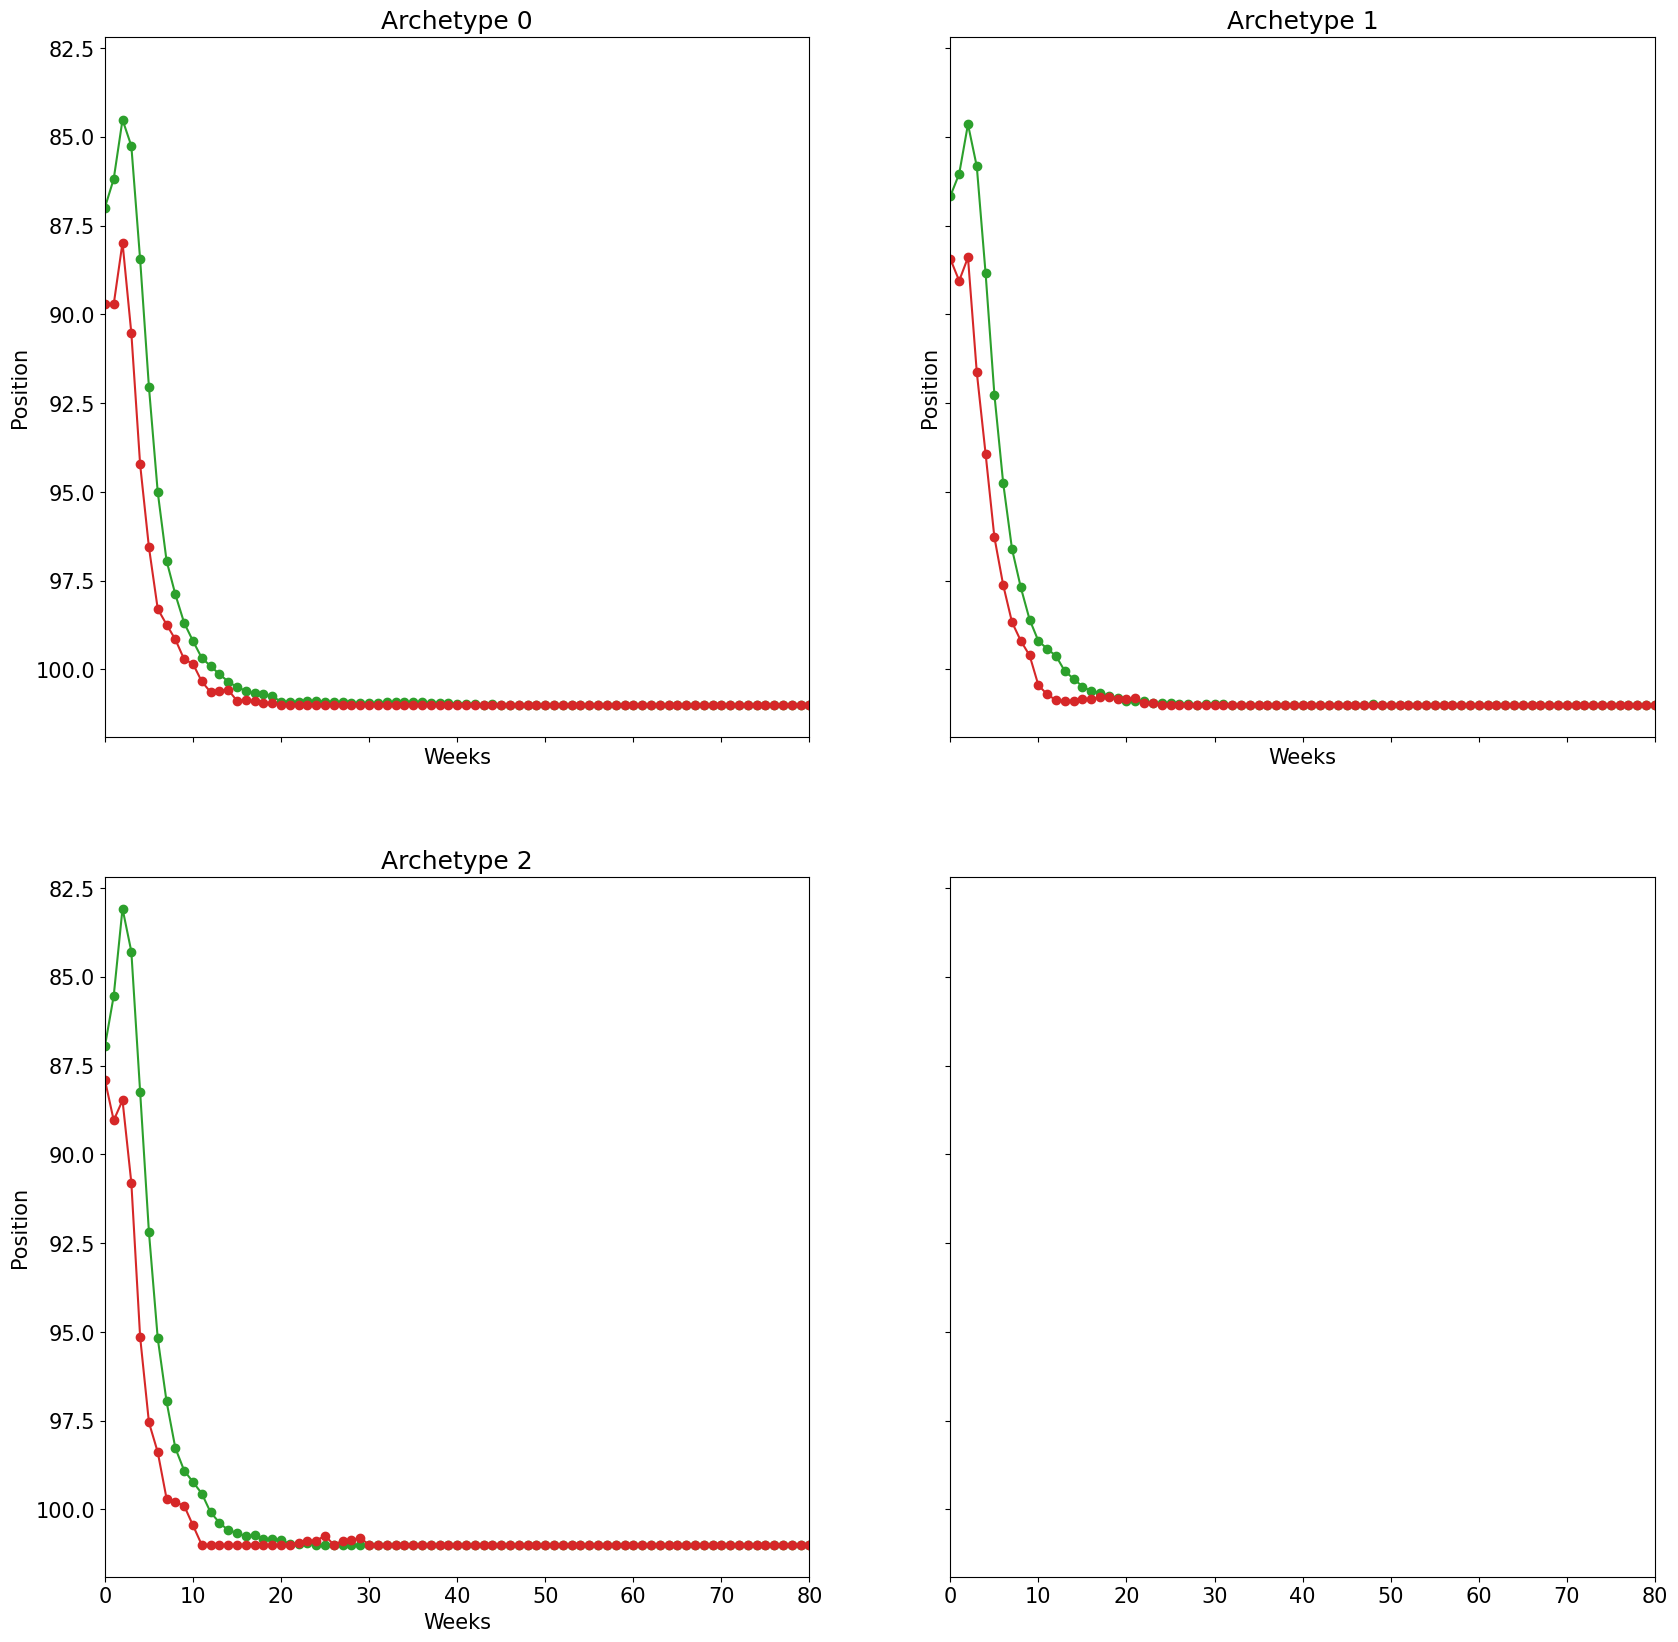

In [109]:
# plot all trajectories of archetypes
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for top_position in range(50, 110, 10):
        songs_ids_from_archetype = archetypes[ix]
        songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        songs_from_archetype = songs_from_archetype[(songs_from_archetype["top_position"] >= top_position) &\
            (songs_from_archetype["top_position"] < top_position + 10)][["artist_song"]]
        songs_from_archetype = songs_from_archetype[["artist_song"]].drop_duplicates().merge(
            billboard_100_with_empty_weeks[["artist_song",
                "position", "first_day_of_the_week", "first_week"]], on=["artist_song"], how="left")
        axes[row_i, col_i].plot(songs_from_archetype.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1324.00it/s]
3it [00:04,  1.66s/it]


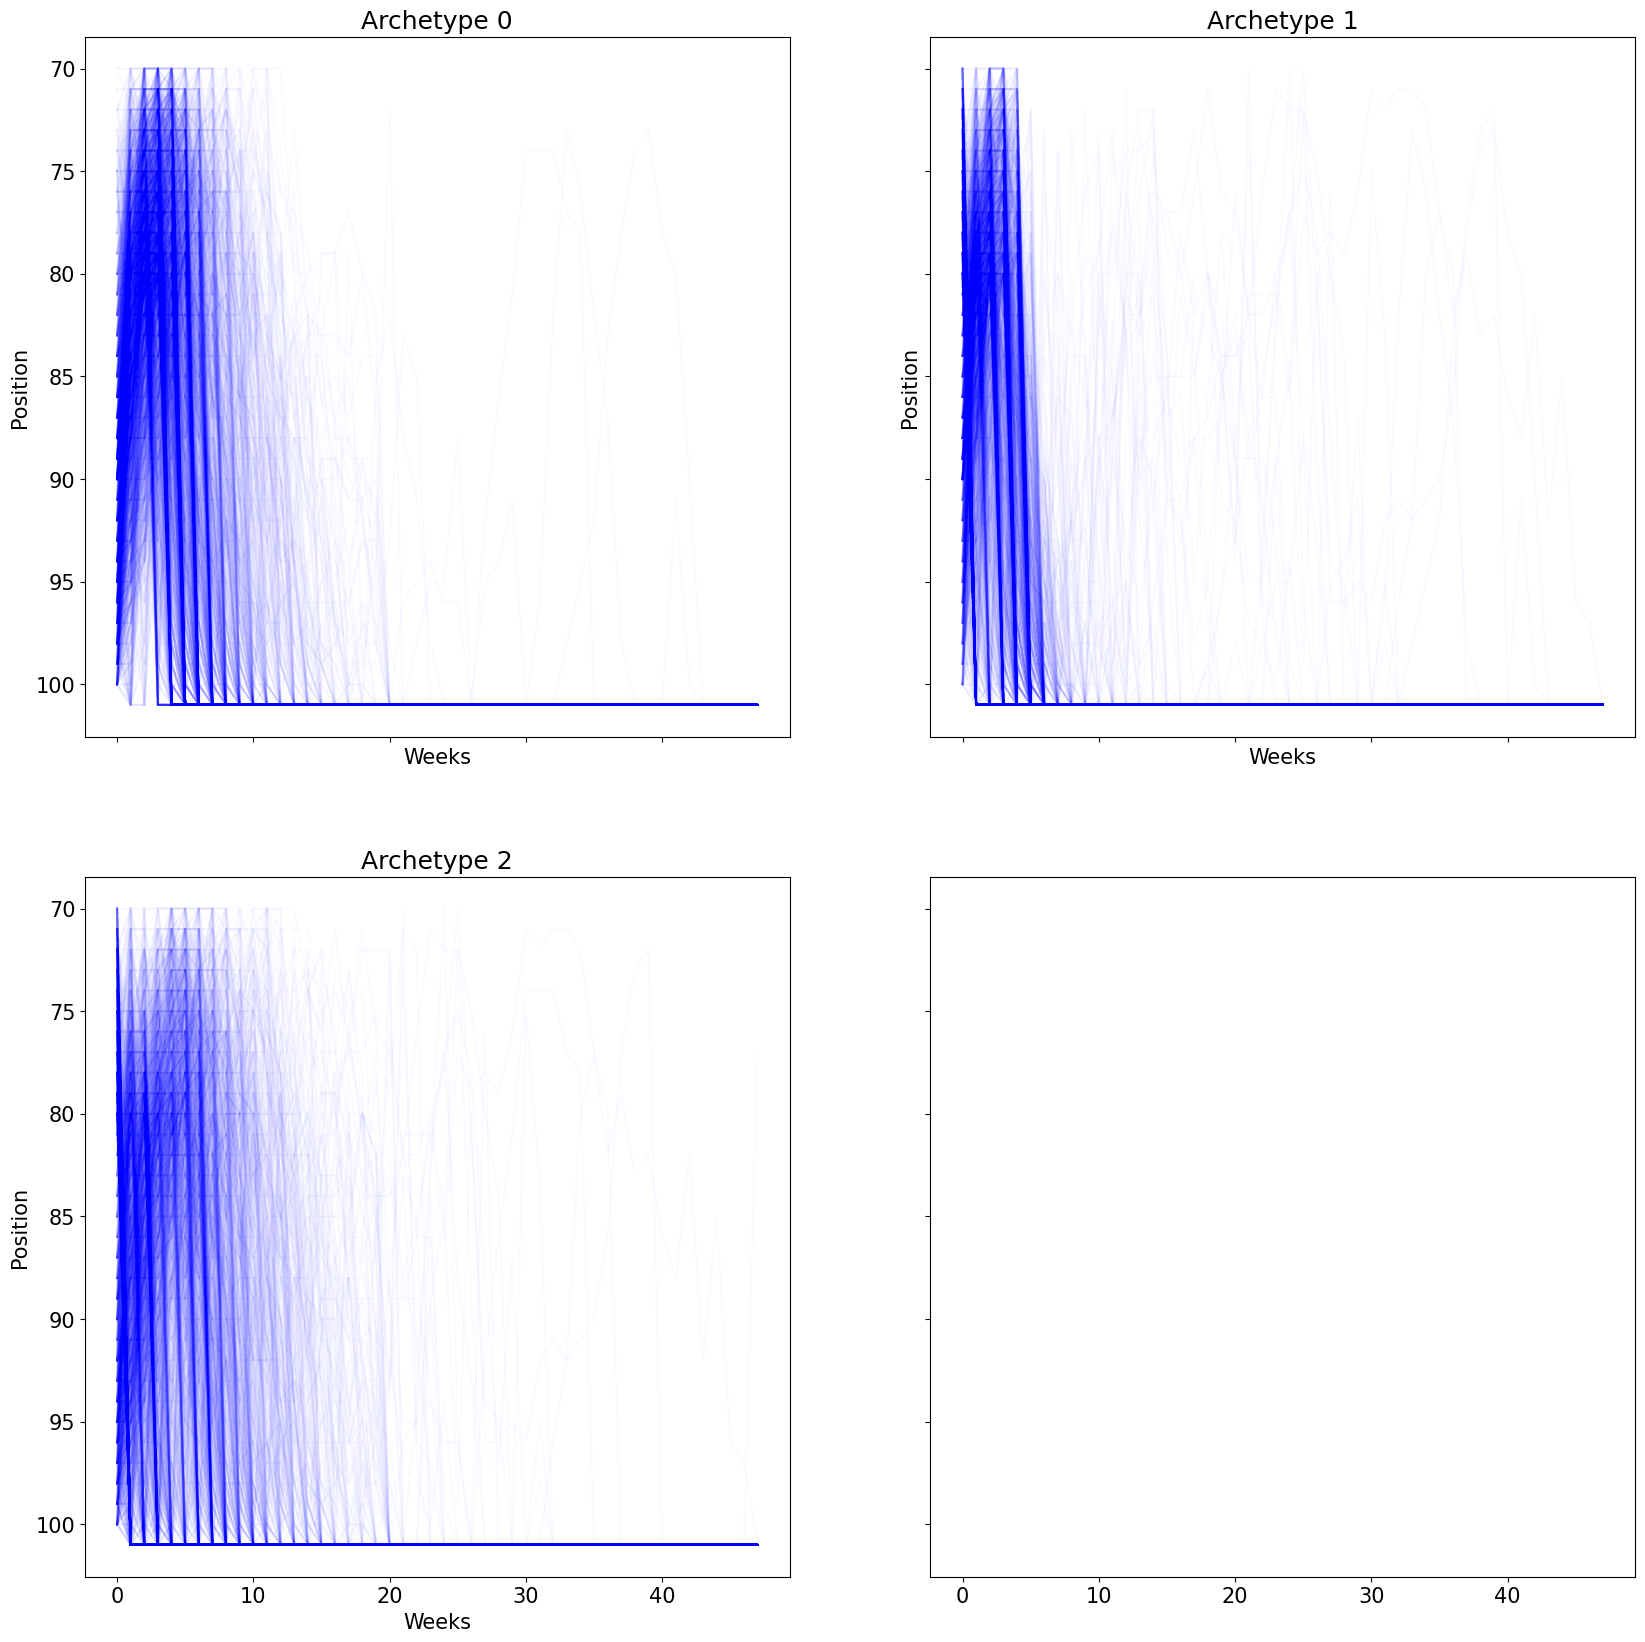

In [110]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = pv_table.iloc[:, i].values
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1513.19it/s]
3it [00:03,  1.31s/it]


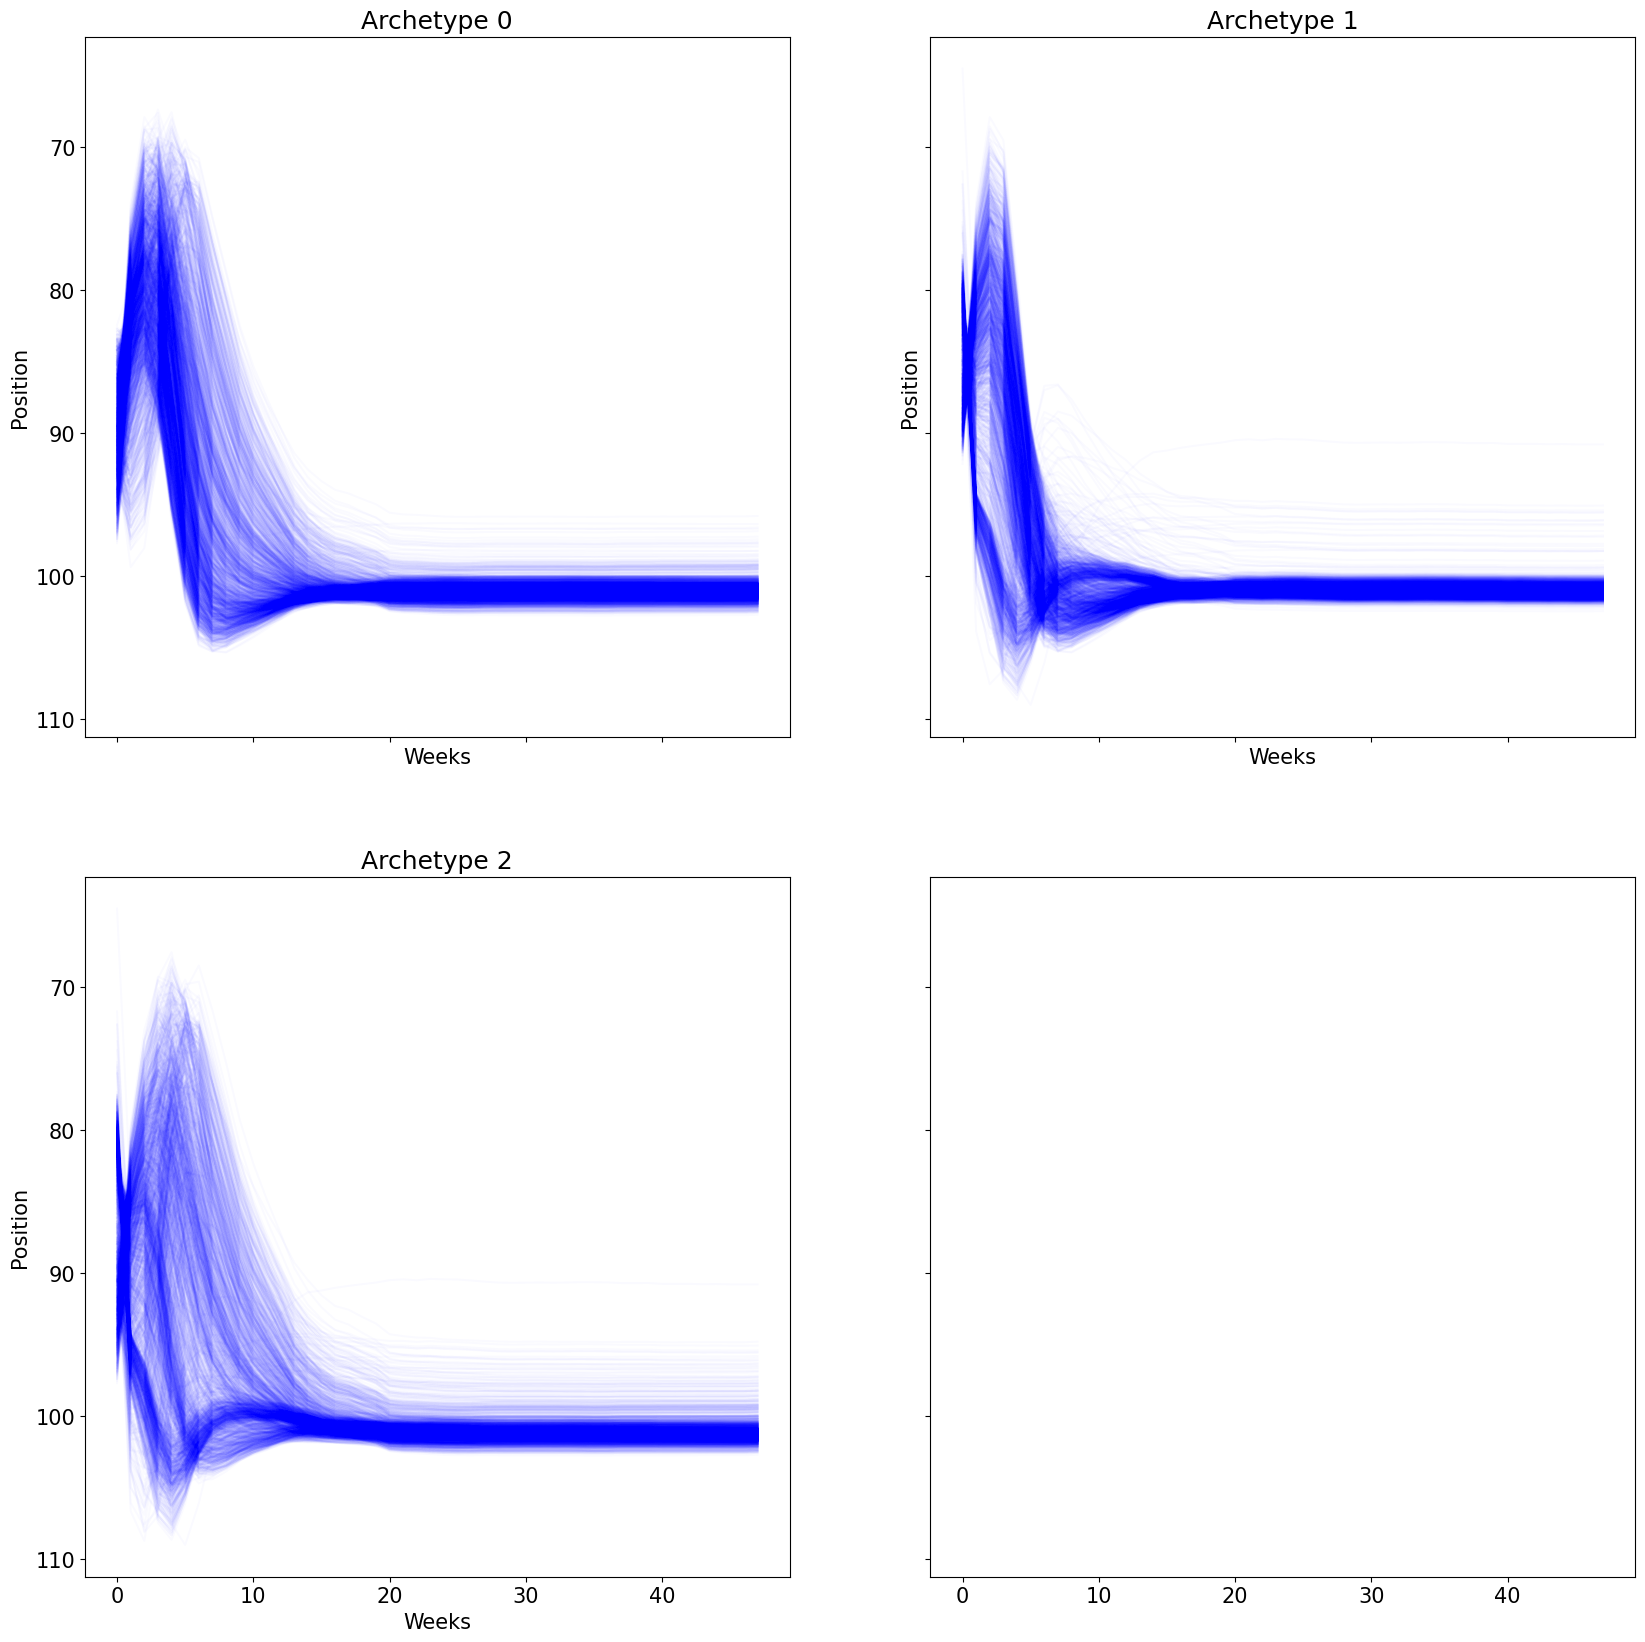

In [111]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = np.matmul(nmf_features_pd, components_df.values[:, i])
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

100%|██████████| 2000/2000 [00:01<00:00, 1857.77it/s]
3it [00:04,  1.39s/it]


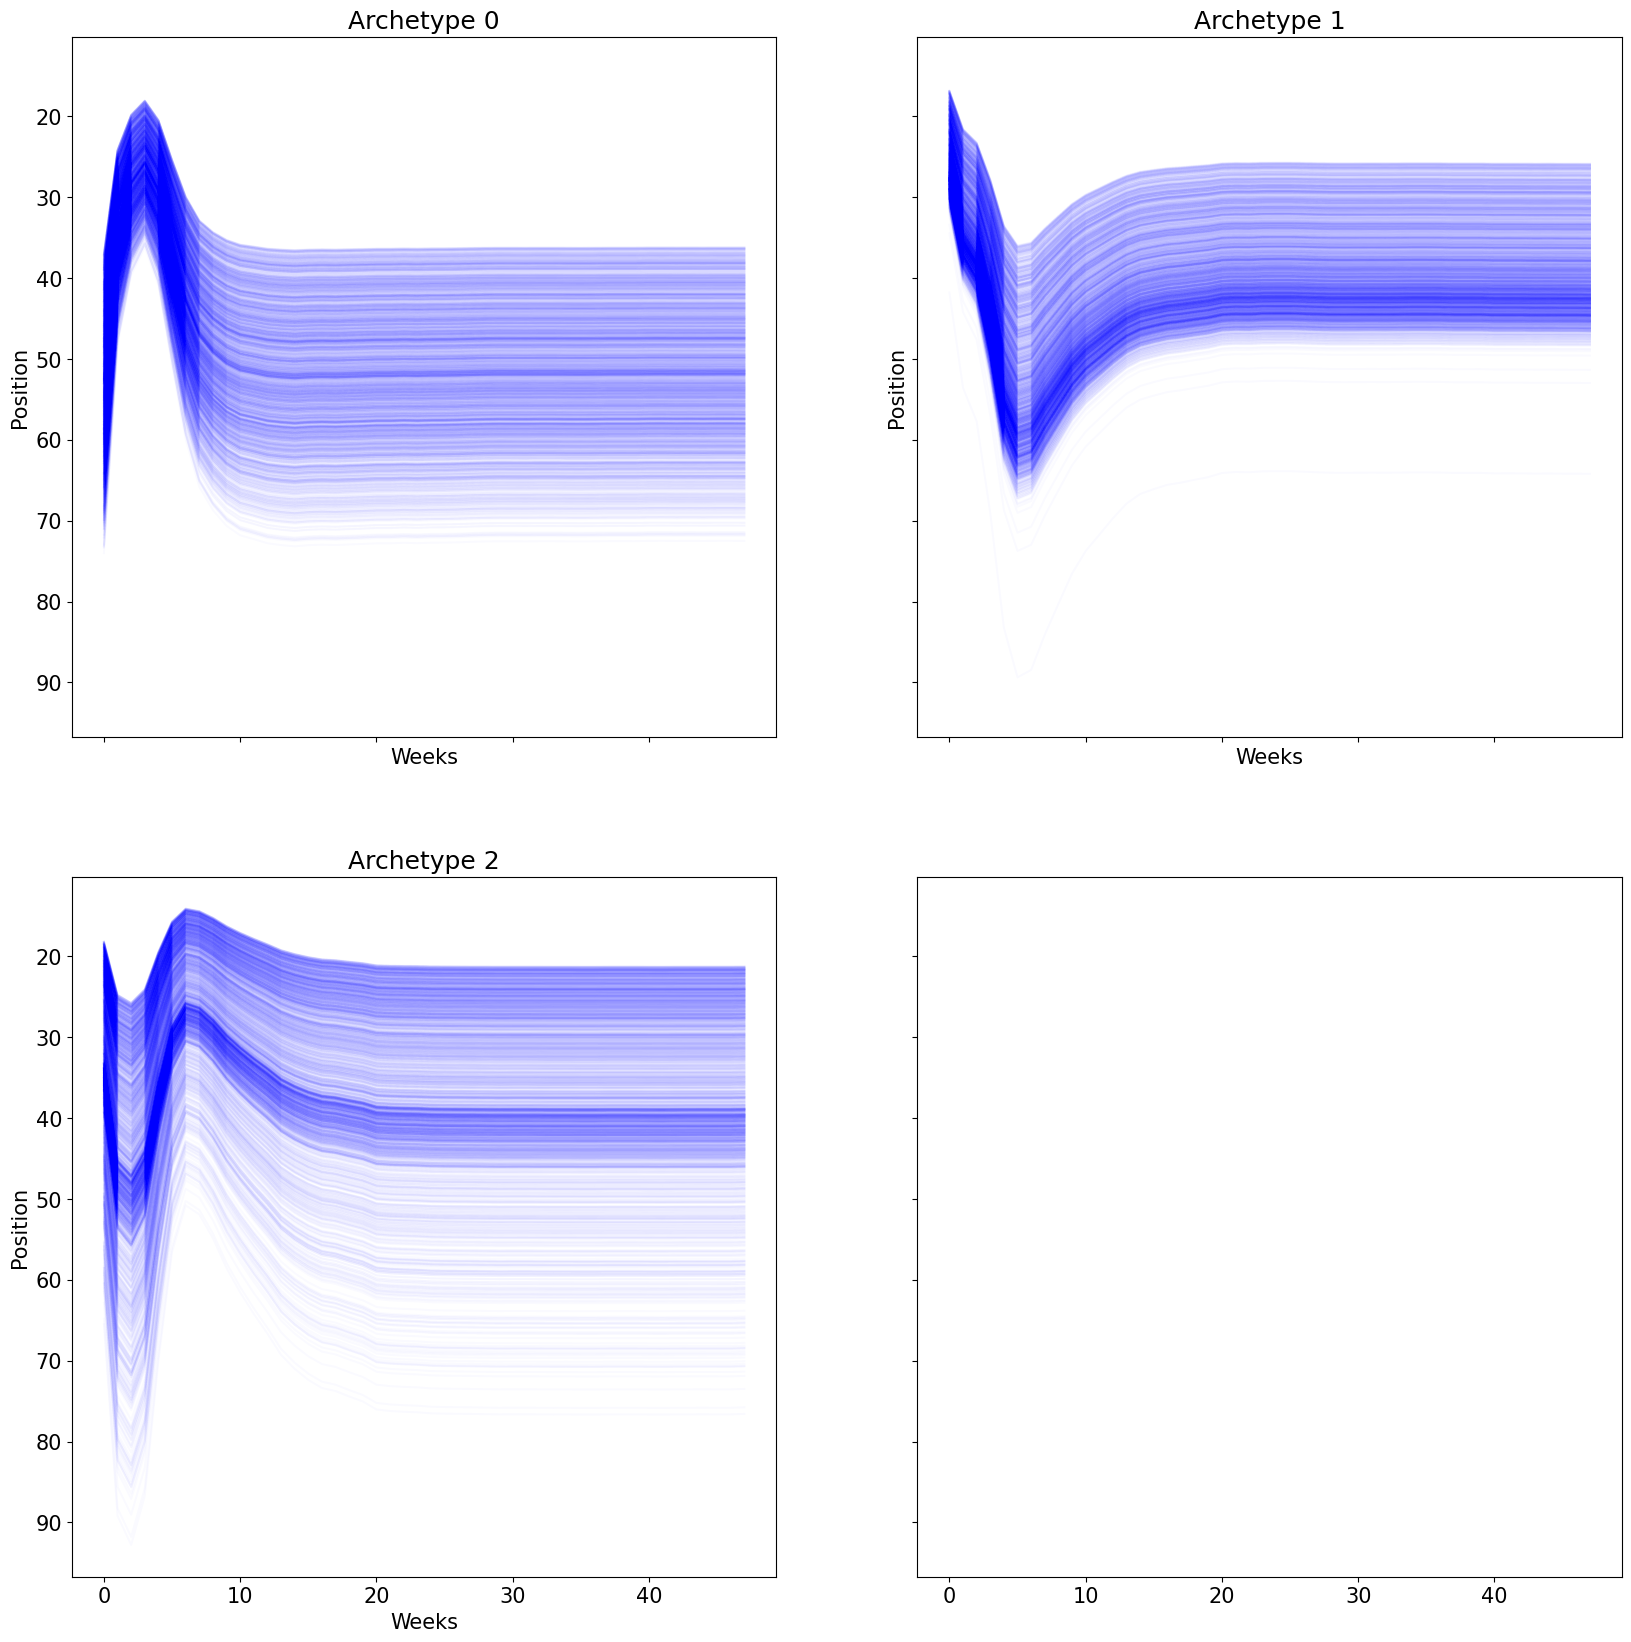

In [112]:
fig, axes = plt.subplots(math.ceil(len(nmf.components_)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for ix, archetype in tqdm(enumerate(nmf.components_)):
    for i in tqdm(archetype.argsort()[:-2000 - 1:-1]):
        # songs_ids_from_archetype = archetypes[ix]
        # songs_from_archetype = billboard_hot_100[billboard_hot_100["artist_song"].isin(songs_ids_from_archetype)]
        trajectory = nmf_features_pd.values[:, ix] * components_df.values[ix, i]
        #trajectory = trajectory[trajectory != 101]
        axes[row_i, col_i].plot(trajectory, alpha=0.02, color="blue")
    
    axes[row_i, col_i].set_title(f"Archetype {ix}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")


    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1 

plt.gca().invert_yaxis()
plt.show()

In [113]:
billboard_hot_100["archetype"] = billboard_hot_100["artist_song"].progress_apply(lambda x: components_df[x].argmax())


100%|██████████| 17580/17580 [00:00<00:00, 18217.60it/s]


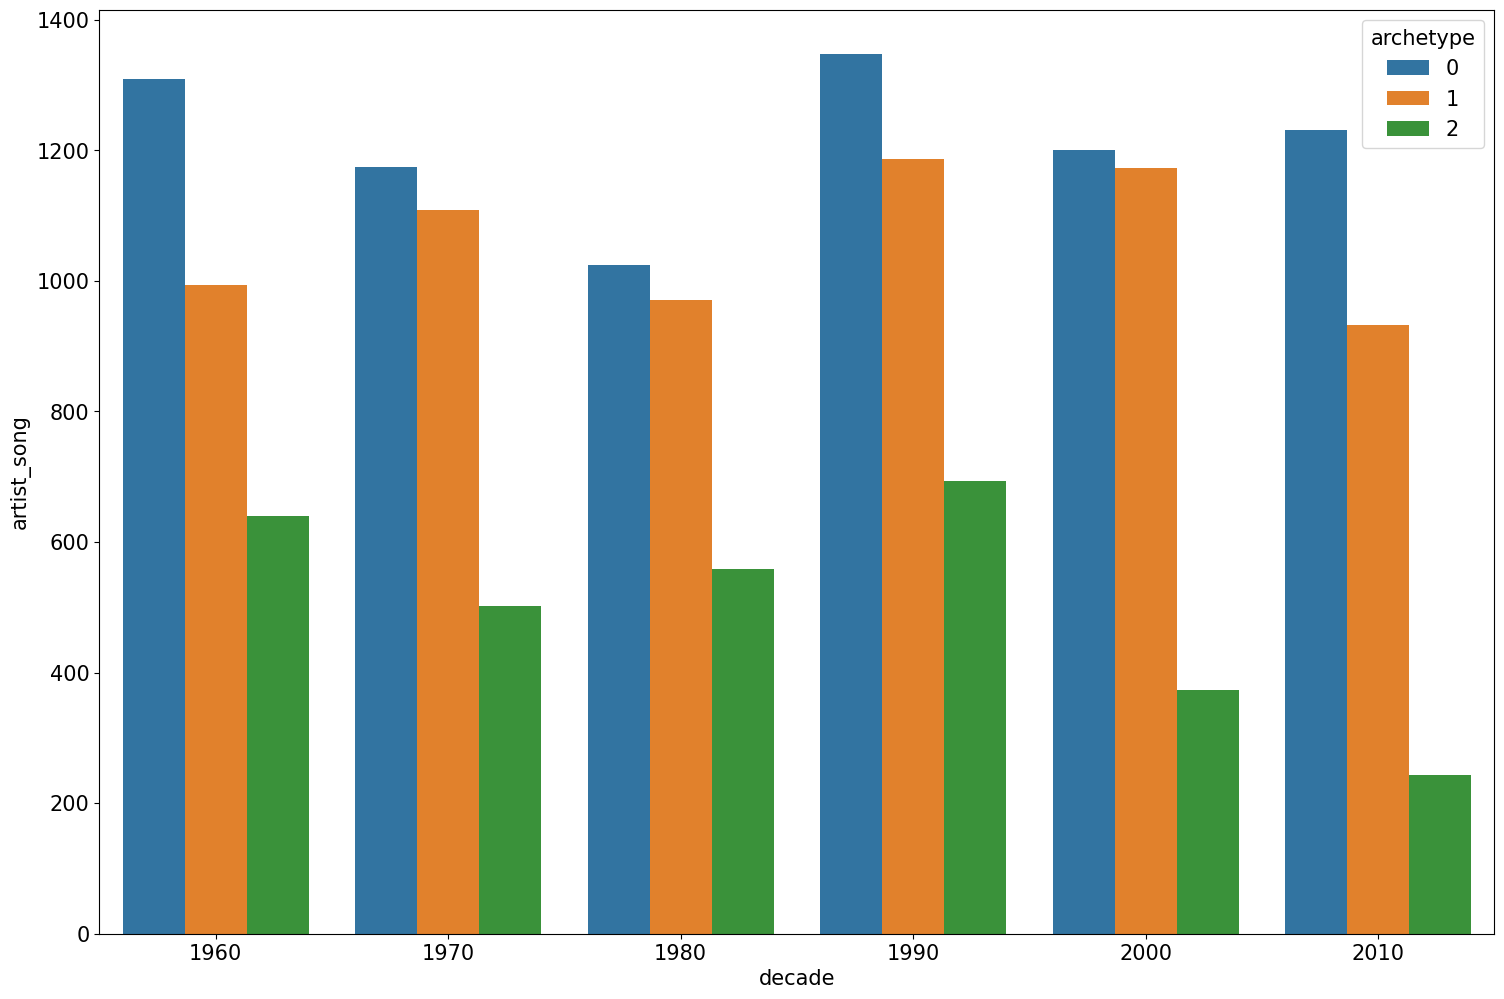

In [114]:
import seaborn as sns

plt.figure(figsize=(18, 12))

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week_copy"].dt.year
billboard_hot_100["decade"] = billboard_hot_100["year"].apply(lambda x: x - x % 10)
counts = billboard_hot_100[["archetype", "decade", "artist_song"]].groupby(["archetype", "decade"]).count().reset_index()
counts = counts[(counts["decade"] != 2020) & (counts["decade"] != 1950)]
sns.barplot(counts, x="decade", y="artist_song", hue="archetype")

plt.show()